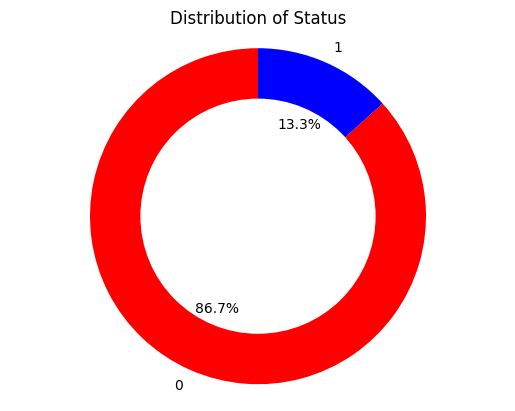

In [12]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import deque
import random
import tensorflow as tf

# %%
# Load dataset
df = pd.read_csv("metrics-with-output.csv")

# %%
# Menampilkan baris pertama dari dataset
df.head()

# %%
# Membandingkan jumlah status Healthy dan Unhealthy dengan donut chart
status_counts = df['Status'].value_counts()

colors = ['red', 'blue']
plt.pie(status_counts, labels=status_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.gca().add_artist(plt.Circle((0, 0), 0.70, fc='white'))  # Menambahkan lingkaran tengah untuk membuat donut chart
plt.axis('equal')  # Memastikan lingkaran berukuran sama sehingga terlihat seperti donut
plt.title('Distribution of Status')
plt.show()


In [13]:

# %%
# Preprocessing data: clean and convert to numeric
df['cpu_usage'] = df['cpu_usage'].str.rstrip('%').astype('float') / 100.0
df['memory_usage'] = df['memory_usage'].str.rstrip('%').astype('float') / 100.0

def clean_bandwidth(value):
    if 'GB/s' in value:
        return float(value.replace('GB/s', ''))
    elif 'MB/s' in value:
        return float(value.replace('MB/s', '')) / 1024  # Convert MB/s to GB/s
    else:
        return float(value)

df['bandwidth_inbound'] = df['bandwidth_inbound'].apply(clean_bandwidth)
df['bandwidth_outbound'] = df['bandwidth_outbound'].apply(clean_bandwidth)
df['tps'] = df['tps'].str.rstrip(' req/s').astype('float')
df['tps_error'] = df['tps_error'].str.rstrip(' req/s').astype('float')
df['response_time'] = df['response_time'].replace({' ms': '*1e-3', ' s': '*1'}, regex=True).map(pd.eval).astype('float')

# Drop irrelevant columns
dataset = df.drop(df.columns[[0, 1]], axis=1)

# Normalize the dataset
scaler = MinMaxScaler()
features = dataset.drop('Status', axis=1)
normalized_features = scaler.fit_transform(features)

# Replace the non-normalized features with the normalized ones in the dataset
normalized_dataset = pd.DataFrame(normalized_features, columns=features.columns)
normalized_dataset['Status'] = dataset['Status'].values  # Add the 'Status' column back
dataset = normalized_dataset


In [14]:


# %%
# Encode 'Status' column into numeric values
label_encoder = LabelEncoder()
dataset['Status'] = label_encoder.fit_transform(dataset['Status'])

# %%
# Split data menjadi features (X) dan target (y)
X = dataset.drop('Status', axis=1)
y = dataset['Status']

# %%
# Normalisasi data
X_scaled = scaler.fit_transform(X)

# %%
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=123)

# %%
# Definisikan Environment Class
class Environment:
    def __init__(self, dataset, class_weights, total_epochs):
        self.dataset = dataset
        self.num_samples = len(dataset)
        self.current_sample_idx = None  # Set indeks sampel saat ini ke None saat inisialisasi
        self.class_weights = class_weights  # Bobot kelas
        self.total_epochs = total_epochs  # Total jumlah epoch
        self.current_epoch = 0  # Epoch saat ini, dimulai dari 0

    def reset(self):
        self.current_sample_idx = 0  # Set ulang indeks sampel saat memulai episode baru
        self.current_epoch += 1  # Tambahkan epoch setiap kali reset
        initial_observation = self.dataset.iloc[self.current_sample_idx]  # Ambil observasi awal
        return initial_observation, 0, False

    def step(self, action):
        actual = self.dataset.iloc[self.current_sample_idx]['Status']  # Menggunakan kolom 'Status' yang ada di dataset
        predicted = action  # Asumsikan 'action' adalah prediksi agen

        # Update indeks sampel
        self.current_sample_idx = (self.current_sample_idx + 1) % self.num_samples
        next_observation = self.dataset.iloc[self.current_sample_idx]
        
        # Hitung reward berdasarkan observasi dan aksi
        reward = self.calculate_reward(
            actual, predicted, self.class_weights, self.current_epoch, self.total_epochs
        )
        
        # Atur done menjadi True jika mencapai akhir episode
        done = self.current_sample_idx == 0
        
        return next_observation, reward, done

    def calculate_reward(self, actual, predicted, class_weights, current_epoch, total_epochs):
        base_penalty = -1
        base_reward = 1
        
        if predicted == actual:
            if actual == 1:
                reward = base_reward * class_weights[1]
            else:
                reward = base_reward * class_weights[0]
        else:
            if predicted == 1:
                penalty = base_penalty * class_weights[1]
            else:
                penalty = base_penalty * class_weights[0]

            reward = penalty * (1 + (current_epoch / total_epochs))
        
        return reward



In [15]:


# %%
# Define DQNAgent Class
class DQNAgent:
    def __init__(self, state_size, action_size, class_weights=None):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.93
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning_rate = 0.001
        self.class_weights = class_weights
        self.model = self._build_model()

    def custom_loss(self, y_true, y_pred):
        weights = tf.where(tf.equal(y_true, 0), 0.2, 0.8)
        loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(loss * weights)

    def _build_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(128, input_dim=self.state_size))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
        model.add(tf.keras.layers.Dropout(0.2))
        
        model.add(tf.keras.layers.Dense(256))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
        model.add(tf.keras.layers.Dropout(0.2))
        
        model.add(tf.keras.layers.Dense(128))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
        model.add(tf.keras.layers.Dropout(0.2))
        
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss=self.custom_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))


    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        # Membagi pengalaman berdasarkan reward
        experiences_class_0 = [exp for exp in self.memory if exp[2] < 0]  # Negative reward indicates class 0
        experiences_class_1 = [exp for exp in self.memory if exp[2] > 0]  # Positive reward indicates class 1

        # Mengecek jika pengalaman kelas 0 lebih kecil dari batch_size
        if len(experiences_class_0) < batch_size // 2:
            minibatch_class_0 = experiences_class_0 * (batch_size // len(experiences_class_0))  # Mengulang data yang ada
            minibatch_class_0 += random.sample(experiences_class_0, batch_size // 2 - len(minibatch_class_0))  # Mengisi kekurangan
        else:
            minibatch_class_0 = random.sample(experiences_class_0, batch_size // 2)

        # Sama untuk kelas 1
        if len(experiences_class_1) < batch_size // 2:
            minibatch_class_1 = experiences_class_1 * (batch_size // len(experiences_class_1))
            minibatch_class_1 += random.sample(experiences_class_1, batch_size // 2 - len(minibatch_class_1))
        else:
            minibatch_class_1 = random.sample(experiences_class_1, batch_size // 2)

        # Gabungkan kedua minibatch
        minibatch = minibatch_class_0 + minibatch_class_1
        
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



# %%
# Parameters
num_actions = 2  # Number of possible actions
num_features = len(dataset.columns) - 1  # Number of features in the dataset (excluding classification)
batch_size = 40
num_episodes = 3000
max_steps = 2000

# %%
# Initialize environment and agent
class_weights = {0:0.7 , 1: 0.3} # Contoh untuk menghitung bobot
env = Environment(dataset, class_weights, num_episodes)
agent = DQNAgent(state_size=num_features, action_size=num_actions, class_weights=class_weights)



In [16]:

# %%
# Training loop
total_reward_all = 0  # Inisialisasi total reward semua episode
total_rewards = []  # Inisialisasi list untuk menyimpan total reward setiap episode

for e in range(num_episodes):
    state, reward, done = env.reset()
    state = np.reshape(state.drop('Status').values, [1, num_features])  # Buang kolom 'Status' saat mengonversi state menjadi array
    total_reward = 0

    for time in range(max_steps):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state.drop('Status').values, [1, num_features])  # Buang kolom 'Status' saat mengonversi state menjadi array
        total_reward += reward
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"Episode {e+1}/{num_episodes}, Total reward: {total_reward}, Epsilon: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    total_reward_all += total_reward
    total_rewards.append(total_reward)

# Calculate the average reward over all episodes
average_reward = total_reward_all / num_episodes
print(f"Average reward over {num_episodes} episodes: {average_reward}")

# %%
# Visualize the reward over episodes
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

# %%
# Confusion Matrix & Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = []
y_true = []

for i in range(len(X_test)):
    state = np.reshape(X_test[i], [1, num_features])
    action = agent.act(state)
    y_pred.append(action)
    y_true.append(y_test.iloc[i])

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print(report)


ValueError: Sample larger than population or is negative